In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import os
import sys
sys.path.append('/Users/datnguyen/Work/others/')

from utils.db_utils import df_from_snowflake
import matplotlib.pyplot as pp

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from chow_test import chow_test
pd.set_option('display.max_rows', None)

/Users/datnguyen/.pyenv/versions/3.11.5/envs/analytics/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [104]:
query_2 = """
with raw_response_unique as (
    select distinct EXPORT_UPDATED_AT_UTC as response_ts
     from stage.main_marketing.adwords_offline_conversions_feedback
     where true
       and EXPORT_UPDATED_AT_UTC >= '2022-01-01'
),
diffs as (
    select response_ts,
     lead(response_ts) over ( order by response_ts asc)                                            as next,
     lead(response_ts)
          over (partition by date_trunc('day', response_ts) order by response_ts asc)              as next_intraday,
     datediff('hour', response_ts, next)                                                           as diff_in_hours,
     datediff('hour', response_ts, next_intraday)                                                  as diff_in_hours_intraday
    from raw_response_unique
    order by response_ts asc
),
    cte_delay as (
        select
            date_trunc('day', response_ts) as dt,
            avg(diff_in_hours) mean,
            stddev(diff_in_hours) std,
            max(diff_in_hours) max,
            avg(diff_in_hours_intraday) mean_intraday,
            stddev(diff_in_hours_intraday) std_intraday,
            max(diff_in_hours_intraday) max_intraday,
            sum(diff_in_hours_intraday) sum_intraday,
            case
                when max_intraday > 12 + {allowance} then 1
                when sum_intraday < 16 - {allowance} then 1
                when max >= 24 then 1
                else 0
            end delay
        from diffs
        group by 1
    ),

    ads_report as (
        select
            date_trunc('day', date) as dt,
            sum(cost) as spend,
            sum(clicks) as clicks,
            sum(revenue) as revenue
        from  STAGE.derived_marketing.google_adwords_ads_report
        where true
            and date >= '2022-01-01'
        group by 1
        order by 1

    ),

    cte_final as (
        select
            date_trunc('week', dt) as week,
            case when sum(delay)>0 then 1 else 0 end as delay_in_week,
            sum(spend) as spend,
            sum(clicks) as clicks,
            sum(revenue) as revenue
        from cte_delay
        full join ads_report using (dt)
        group by all
    )


select *
from cte_final
where week < current_date()
order by week
""".format(allowance=8)

In [105]:
df_2 = df_from_snowflake(query=query_2)

In [106]:
df_2['LOG_REV'] = np.log(df_2['REVENUE'])
df_2['LOG_CLICKS'] = np.log(df_2['CLICKS'].astype('float'))
df_2['LOG_SPEND'] = np.log(df_2['SPEND'])
df_2.tail(20)

,WEEK,DELAY_IN_WEEK,SPEND,CLICKS,REVENUE,LOG_REV,LOG_CLICKS,LOG_SPEND
131,2024-07-01,0,1.566706e+06,3467261,1.512964e+06,14.229581,15.058876,14.264486
132,2024-07-08,0,1.321707e+06,3300147,1.400448e+06,14.152303,15.009478,14.094434
133,2024-07-15,0,1.084080e+06,2991637,1.212705e+06,14.008364,14.911331,13.896242
134,2024-07-22,0,1.007198e+06,2849594,1.137355e+06,13.944216,14.862687,13.822683
135,2024-07-29,0,9.381046e+05,2847751,1.112886e+06,13.922467,14.862040,13.751617
136,2024-08-05,0,1.257806e+06,3689184,1.474297e+06,14.203692,15.120916,14.044879
137,2024-08-12,0,1.427484e+06,4659941,1.523692e+06,14.236647,15.354513,14.171424
138,2024-08-19,0,1.002276e+06,3019472,1.034499e+06,13.849428,14.920593,13.817784
139,2024-08-26,0,8.506282e+05,2240136,9.093884e+05,13.720528,14.622047,13.653730
140,2024-09-02,0,9.748320e+05,1828755,9.240442e+05,13.736515,14.419146,13.790020


In [107]:
df_2['DELAY_IN_WEEK'].sum()

21

In [83]:
df_2[df_2['DELAY_IN_WEEK']> 0]['WEEK']

4     2022-01-24
11    2022-03-14
28    2022-07-11
29    2022-07-18
35    2022-08-29
53    2023-01-02
59    2023-02-13
64    2023-03-20
68    2023-04-17
69    2023-04-24
70    2023-05-01
72    2023-05-15
74    2023-05-29
75    2023-06-05
79    2023-07-03
90    2023-09-18
91    2023-09-25
95    2023-10-23
102   2023-12-11
122   2024-04-29
148   2024-10-28
Name: WEEK, dtype: datetime64[ns]

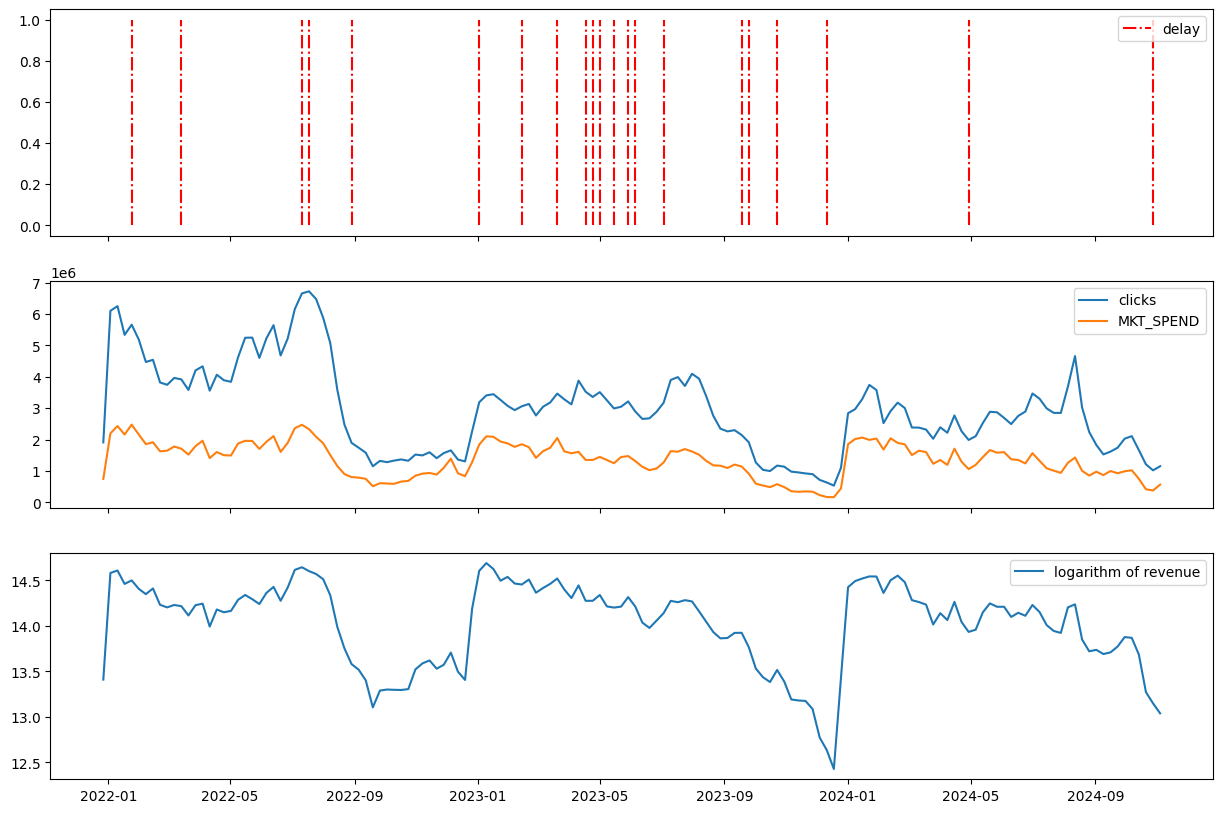

In [84]:
_, ax = pp.subplots(nrows=3, ncols=1, sharex=True, figsize=(15,10))

ax[0].vlines(df_2[df_2['DELAY_IN_WEEK']> 0]['WEEK'],
             ymin=0,
             ymax=1,
           label='delay',
           color='red',
           ls='-.'
           )
# ax[0].set_ylim(0.8,)

ax[1].plot(
    df_2['WEEK'],
    df_2['CLICKS'],
    label='clicks'
)

ax[2].plot(
    df_2['WEEK'],
    df_2['LOG_REV'],
    label='logarithm of revenue'
)

# ax[3].plot(
#     df_2['WEEK'],
#     df_2['REVENUE']/df_2['CLICKS'],
#     label='rev per click'
# )

ax[1].plot(
    df_2['WEEK'],
    df_2['SPEND'],
    label='MKT_SPEND'
)

for i in ax:
    i.legend()


# Using Prophet

In [21]:
prophet_df = df_2[['WEEK','LOG_REV']]
prophet_df.columns = ['ds', 'y']
# prophet_df['y'].astype(float)

In [22]:
m = Prophet()
m.fit(prophet_df)

23:40:57 - cmdstanpy - INFO - Chain [1] start processing
23:40:57 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
forecast = m.predict()
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

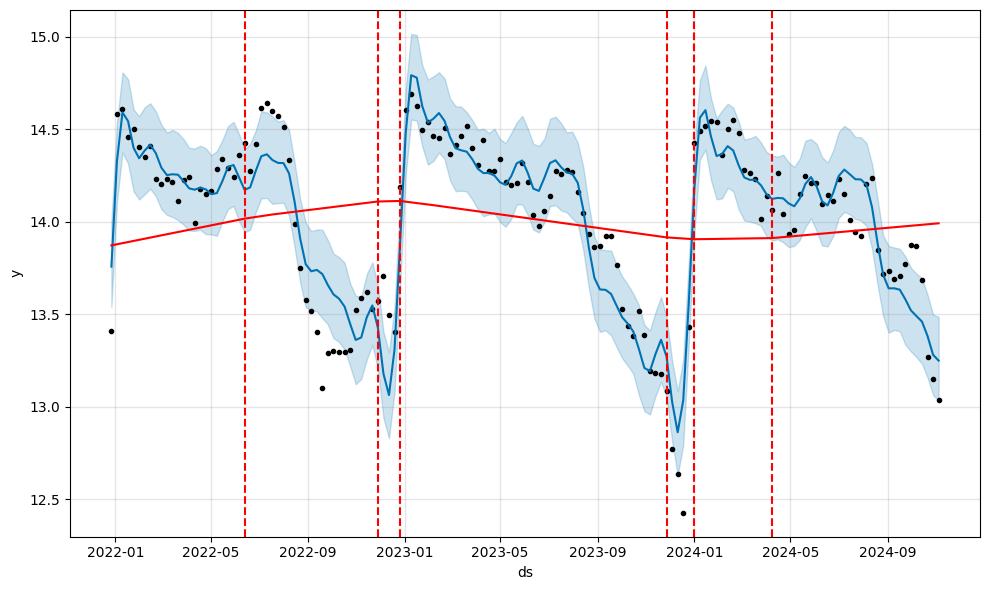

In [25]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [26]:
m.changepoints

5     2022-01-31
10    2022-03-07
14    2022-04-04
19    2022-05-09
24    2022-06-13
29    2022-07-18
33    2022-08-15
38    2022-09-19
43    2022-10-24
48    2022-11-28
52    2022-12-26
57    2023-01-30
62    2023-03-06
67    2023-04-10
71    2023-05-08
76    2023-06-12
81    2023-07-17
86    2023-08-21
90    2023-09-18
95    2023-10-23
100   2023-11-27
105   2024-01-01
109   2024-01-29
114   2024-03-04
119   2024-04-08
Name: ds, dtype: datetime64[ns]

In [85]:
df_2[['WEEK','DELAY_IN_WEEK']][df_2.DELAY_IN_WEEK > 0]

,WEEK,DELAY_IN_WEEK
4,2022-01-24,1
11,2022-03-14,1
28,2022-07-11,1
29,2022-07-18,1
35,2022-08-29,1
53,2023-01-02,1
59,2023-02-13,1
64,2023-03-20,1
68,2023-04-17,1
69,2023-04-24,1


## Chow test

In [65]:
# from statsmodels.tsa.seasonal import STL

# def decompose_seasonality(data,revenue_column):
#     """return residuals from decomposition process"""
#     stl = STL(data.iloc[:, revenue_column], period=365, seasonal=13, robust=True) 
#     result = stl.fit()
#     return result.resid, result.trend, result.seasonal 

In [28]:
# # DECOMPOSE
# df_2['REV_PER_CLICK'] = df_2['REVENUE']/df_2['CLICKS']

# stl = STL(df_2['REV_PER_CLICK'] , period=365, seasonal=13, robust=True) 
# result = stl.fit()
# result.plot()
# pp.show()

In [29]:

X = pd.DataFrame(df_2.index)
Y = pd.Series(df_2['LOG_REV']).astype('float')

# Y_hat = pd.Series(result.resid).astype('float')

#### TEST ON DELAY SIGNALS

In [87]:
chow_test(X_series=X, y_series=Y, last_index=53, first_index=54, significance=0.05)

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 16.9498764305875, P_value: 2.4264646425464775e-07


(16.9498764305875, 2.4264646425464775e-07)

In [94]:
chow_test(X_series=X, y_series=Y, last_index=102, first_index=103, significance=0.05)

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 12.929814064613815, P_value: 6.804865475107391e-06


(12.929814064613815, 6.804865475107391e-06)

In [86]:
chow_test(X_series=X, y_series=Y, last_index=29, first_index=30, significance=0.05)

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 3.8628608279003185, P_value: 0.023203135829681587


(3.8628608279003185, 0.023203135829681587)

#### TEST ON NORMAL SIGNALS

In [99]:
chow_test(X_series=X, y_series=Y, last_index=37, first_index=38, significance=0.05)

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 3.4989447750313065, P_value: 0.032806297016986896


(3.4989447750313065, 0.032806297016986896)

In [101]:
chow_test(X_series=X, y_series=Y, last_index=111, first_index=112, significance=0.05)

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 9.147514604096067, P_value: 0.00018140122524323843


(9.147514604096067, 0.00018140122524323843)

## REGRESSION

In [71]:
import statsmodels.api as sm

In [114]:
input = df_2
input['DELAYLAG1'] = input['DELAY_IN_WEEK'].shift(1)
input['DELAYLAG2'] = input['DELAY_IN_WEEK'].shift(2)
input['DELAYLAG8'] = input['DELAY_IN_WEEK'].shift(8)
input['DELAYLAG4'] = input['DELAY_IN_WEEK'].shift(4)
input['REV_PER_CLICK'] = input['REVENUE']/input['CLICKS'].astype(float)
input['REV_PER_SPEND'] = input['REVENUE']/input['SPEND']
input = input.fillna(0)
input.exog = sm.add_constant(input[['DELAYLAG1','DELAYLAG2','DELAYLAG4','DELAYLAG8', 'DELAY_IN_WEEK','LOG_CLICKS', 'LOG_SPEND']].astype(float))
input.endog = input['REV_PER_SPEND'].astype(float)

reg = sm.GLM(input.endog, input.exog, family=sm.families.Gamma())
result = reg.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          REV_PER_SPEND   No. Observations:                  151
Model:                            GLM   Df Residuals:                      143
Model Family:                   Gamma   Df Model:                            7
Link Function:           InversePower   Scale:                        0.019418
Method:                          IRLS   Log-Likelihood:                 61.566
Date:                Tue, 12 Nov 2024   Deviance:                       3.6765
Time:                        15:14:52   Pearson chi2:                     2.78
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3819
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.2565      0.256     -1.000

/var/folders/lj/9ds87q3x3q15md0t2hlkfm_h0000gn/T/ipykernel_66180/996078824.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  input.exog = sm.add_constant(input[['DELAYLAG1','DELAYLAG2','DELAYLAG4','DELAYLAG8', 'DELAY_IN_WEEK','LOG_CLICKS', 'LOG_SPEND']].astype(float))
/var/folders/lj/9ds87q3x3q15md0t2hlkfm_h0000gn/T/ipykernel_66180/996078824.py:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  input.endog = input['REV_PER_SPEND'].astype(float)
/Users/datnguyen/.pyenv/versions/3.11.5/envs/analytics/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


In [73]:
input

,WEEK,DELAY_IN_WEEK,SPEND,CLICKS,REVENUE,LOG_REV,LAG_DELAY
1,2022-01-03,0,2.196230e+06,6102620,2.151103e+06,14.581491,0.0
2,2022-01-10,0,2.430360e+06,6250611,2.211222e+06,14.609056,0.0
3,2022-01-17,0,2.159364e+06,5336418,1.907302e+06,14.461200,0.0
4,2022-01-24,1,2.475834e+06,5659685,1.982743e+06,14.499992,0.0
5,2022-01-31,0,2.159317e+06,5187853,1.806518e+06,14.406912,1.0
6,2022-02-07,0,1.854451e+06,4471438,1.704669e+06,14.348881,0.0
7,2022-02-14,0,1.912678e+06,4540418,1.815164e+06,14.411686,0.0
8,2022-02-21,1,1.624564e+06,3818955,1.515748e+06,14.231420,0.0
9,2022-02-28,0,1.645267e+06,3744428,1.473619e+06,14.203232,1.0
10,2022-03-07,0,1.777543e+06,3963234,1.513361e+06,14.229844,0.0


## EXTRA

In [57]:
df_3 = df_from_snowflake(query=query_3)
df_3

ProgrammingError: 000904 (42000): SQL compilation error: error line 39 at position 16
invalid identifier 'LEGAL_ENTITY_SHORT_NAME'